# Import Packages

In [ ]:
import pandas as pd
import numpy as np
import os as os 
import random 
import sys 
import datetime as dt 
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle
from keras import backend as K 
import zipfile
! pip install xlrd # need to read in the xlsx sheet later
! pip install image-classifiers
from classification_models.keras import Classifiers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
!pip install tqdm
from tqdm.notebook import tqdm

     |████████████████████████████████| 50 kB 5.5 MB/s 


# Set Seeds

In [ ]:
tf.random.set_seed(261)
random.seed(1126)
np.random.seed(1030)

# Mount Drive

Load in the CheXpert data as the ZIP downloaded from their website. Unzip using code below. Need to run again if runtime is disconnected.

Also need to upload the CHEXPERT DEMO Excel file. The original dataset does not contain the `race` labels. The DEMO file is what maps the pictures to the `race` labels.

The data will come in on the left as so: 

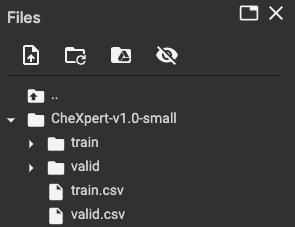

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# QJ's base directory:
base_dir = 'drive/My Drive/'

# CheXpert directory after unzipping
chexpert_dir = "CheXpert-v1.0-small/"
chexper_train_dir = "CheXpert-v1.0-small/train/"
chexper_test_dir = "CheXpert-v1.0-small/valid/"

Mounted at /content/drive


# Unzip Dataset

In [ ]:
# takes 2 min to run
zip_ref = zipfile.ZipFile(base_dir + 'CheXpert-v1.0-small.zip', 'r')
zip_ref.extractall()
zip_ref.close()

# Bring in Main Label Files


In [ ]:
train_labels = pd.read_csv(chexpert_dir + 'train.csv')
test_labels = pd.read_csv(chexpert_dir + 'valid.csv')

# Bring in Race Labels

In [ ]:
# rename the PATIENT column as ID for joining later
race_labels = pd.read_excel(base_dir + 'CHEXPERT DEMO.xlsx').rename(columns = {'PATIENT' : 'ID'})

In [ ]:
race_labels.head(5)

,ID,GENDER,AGE_AT_CXR,PRIMARY_RACE,ETHNICITY
0,patient24428,Male,61,White,Non-Hispanic/Non-Latino
1,patient48289,Female,39,Other,Hispanic/Latino
2,patient33856,Female,81,White,Non-Hispanic/Non-Latino
3,patient41673,Female,42,Unknown,Unknown
4,patient48493,Male,71,White,Non-Hispanic/Non-Latino


# Code Race Labels

For race, we decided to run a model predicting the following for racial categories: Asian, Black, White, and Native American .

The original CheXpert data has more race categories. However, the amount of training data for certain groups was so low, we did not think it would yield strong results. Hispanic was folded into other racial groups as "Racial Group" + (non)Hispanic. For simplicity, we ignored the non-Hispanic/Hispanic labeling and combined American Indian with Native American. Due to low number of observations, we took out Pacific Islander and photos where race is unknown. 

### Merge Race Labels with Original Label data (Train)

In [ ]:
train_labels.head(5)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [ ]:
race_labels.PRIMARY_RACE.unique()

array(['White', 'Other', 'Unknown', 'White, non-Hispanic', 'Asian', nan,
       'Black or African American', 'Black, non-Hispanic',
       'Other, Hispanic', 'Race and Ethnicity Unknown',
       'Asian, non-Hispanic', 'Pacific Islander, non-Hispanic',
       'Native Hawaiian or Other Pacific Islander', 'Other, non-Hispanic',
       'Patient Refused', 'White, Hispanic', 'Black, Hispanic',
       'Asian, Hispanic', 'American Indian or Alaska Native',
       'Native American, Hispanic', 'Native American, non-Hispanic',
       'Pacific Islander, Hispanic', 'Asian - Historical Conv',
       'White or Caucasian'], dtype=object)

In [ ]:
# extract the patient id number from the Path variable (index 2 in the path)
path_split_train =  train_labels.Path.str.split("/", expand = True)
train_labels['ID'] = path_split_train[2]

# merge the race labels with the main label dataset
train_labels = train_labels.merge(race_labels, on = 'ID')

In [ ]:
train_labels.head(5)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,ID,GENDER,AGE_AT_CXR,PRIMARY_RACE,ETHNICITY
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,1.0,patient00001,Female,68,Other,Non-Hispanic/Non-Latino
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,NaN,-1.0,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,patient00003,Male,41,"White, non-Hispanic",Non-Hispanic/Non-Latino


### Adjust Race Labels

Again, we are compressing our race labels into 4 categories: Asian, Black/African American, White, and Native American

In [ ]:
# need na = False bc we want missing values to be coerced to False instead of nan

black_african_american_index = (train_labels.PRIMARY_RACE.str.contains('Black', na = False))
train_labels.loc[black_african_american_index, 'Race'] = 'Black/African American'

white_index = (train_labels.PRIMARY_RACE.str.contains('White', na = False))
train_labels.loc[white_index, 'Race'] = 'White'

asian_index = (train_labels.PRIMARY_RACE.str.contains('Asian', na = False))
train_labels.loc[asian_index, 'Race'] = 'Asian'

native_american_index = (train_labels.PRIMARY_RACE.str.contains('Native|Indian', na = False, regex = True))
train_labels.loc[native_american_index, 'Race'] = 'Native American'

In [ ]:
train_labels.head(20)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pleural Effusion,Pleural Other,Fracture,Support Devices,ID,GENDER,AGE_AT_CXR,PRIMARY_RACE,ETHNICITY,Race
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,patient00001,Female,68,Other,Non-Hispanic/Non-Latino,NaN
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino,White
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino,White
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino,White
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,patient00003,Male,41,"White, non-Hispanic",Non-Hispanic/Non-Latino,White
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,patient00004,Female,20,Black or African American,Non-Hispanic/Non-Latino,Black/African American
6,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Lateral,NaN,1.0,0.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,patient00004,Female,20,Black or African American,Non-Hispanic/Non-Latino,Black/African American
7,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,1.0,patient00005,Male,33,White,Non-Hispanic/Non-Latino,White
8,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Lateral,NaN,1.0,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,1.0,patient00005,Male,33,White,Non-Hispanic/Non-Latino,White
9,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,patient00005,Male,33,White,Non-Hispanic/Non-Latino,White


In [ ]:
train_labels.Race.value_counts(dropna = False)

White                     125491
NaN                        58491
Asian                      23272
Black/African American     11961
Native American             3346
Name: Race, dtype: int64

In [ ]:
sum(train_labels.Race.value_counts(dropna = False))

222561

# Split into Train, Val, Test

This dataset was originally released for a competition. Thus the files are split into `Train` and `Validation`. The `Train` set has 222561 observations while the `Validation` set only has 232 (both numbers are before taking out NAs). 

For the sake of practicality, we are going to split our `train` data into train, test, and val. 


*   test = 10%
*   val = 27%
*   train = 63%



In [ ]:
train_labels = train_labels.dropna(subset=['Race'])

train, test = train_test_split(train_labels, test_size = 0.10, random_state = 261, stratify = train_labels[['Race']])

train, val = train_test_split(train, test_size = 0.30, random_state = 261, stratify = train[['Race']])

In [ ]:
print(len(train))
print(len(val))
print(len(test))

103364
44299
16407


# Transfer Learning: Building a model from Scratch

### Define input size

Images are between about 320-370 by 320-370

In [ ]:
target_height = 150
target_width = 150
size = (target_height, target_width)
size_3d = (target_height, target_width, 3)
number_classes = 4 

### Get Model Base

In [ ]:
ResNet34, preprocess_input = Classifiers.get('resnet34')
model = ResNet34(input_shape = size_3d, weights=None, include_top = False) # random weights used

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 150, 150, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']     

In [ ]:
# ResNet34, preprocess_input = Classifiers.get('resnet34')
# conv_base = ResNet34(input_shape = size_3d, include_top = False) # by default, it brings in the imagenet weights

# conv_base.summary()

After running through the convolution layers, the ouput is 10 by 10 by 512. 

### Create our data generators and define batch size

In [ ]:
batch = 20
epoch_number = 30 

In [ ]:
epoch_number = 30 

training_length = len(train)
validation_length = len(val)
test_length = len(test) 

print(training_length)
print(validation_length)
print(test_length)

# create steps for train, val, and test for later
def steps(length, batch): 
  if length % batch == 0:
    return (int(length / batch))
  else:
    return (int((length / batch) + 1))

training_steps = steps(training_length, batch)
validation_steps = steps(validation_length, batch)
test_steps = steps(test_length, batch)
print(training_steps)
print(validation_steps)
print(test_steps)

103364
44299
16407
5169
2215
821


In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    fill_mode = 'constant',
    rotation_range = 10,
    horizontal_flip = True, 
    zoom_range = 0.05
)

val_test_datagen = ImageDataGenerator(
    rescale = 1./255, 
    fill_mode = 'constant',
    rotation_range = 10,
    horizontal_flip = True, 
    zoom_range = 0.05
)

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory = None, # don't need to specify directory bc our train df has absolute paths to photos
    x_col = "Path", # specify column with path information to photos
    y_col = "Race", # specify where to find classes
    class_mode = "categorical", # specify what kind of classes, for multi use 'categorical'
    target_size = size, # need to put in input size 
    shuffle = True,
    seed = 261,
    batch_size = batch)

val_generator = val_test_datagen.flow_from_dataframe(
    val, 
    directory = None, # don't need to specify directory bc our train df has absolute paths to photos
    x_col = "Path", # specify column with path information to photos
    y_col = "Race", # specify where to find classes
    class_mode = "categorical", # specify what kind of classes, for multi use 'categorical'
    target_size = size, # need to put in input size 
    shuffle = True,
    seed = 261,
    batch_size = batch)

test_generator = val_test_datagen.flow_from_dataframe(
    test, 
    directory = None, # don't need to specify directory bc our train df has absolute paths to photos
    x_col = "Path", # specify column with path information to photos
    y_col = "Race", # specify where to find classes
    class_mode = "categorical", # specify what kind of classes, for multi use 'categorical'
    target_size = size, # need to put in input size 
    shuffle = True,
    seed = 261,
    batch_size = batch)

Found 103364 validated image filenames belonging to 4 classes.
Found 44299 validated image filenames belonging to 4 classes.
Found 16407 validated image filenames belonging to 4 classes.


In [ ]:
#np.savetxt("train_features.csv", train_features, delimiter=",")
#np.savetxt("train_labels.csv", train_labels, delimiter=",")

#np.savetxt("validation_features.csv", validation_features, delimiter=",")
#np.savetxt("validation_labels.csv", validation_labels, delimiter=",")

#np.savetxt("test_features.csv", test_features, delimiter=",")
#np.savetxt("test_labels.csv", test_labels, delimiter=",")

In [ ]:
model_final = tf.keras.models.Sequential([
    model,
    keras.layers.Flatten(),
    keras.layers.Dense(number_classes, activation='softmax')]
)

#x = model.output
#predictions = keras.layers.Dense(number_classes, activation= 'softmax')(x)
#model = tf.keras.Model(inputs = model.input, outputs = predictions)

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

model_final.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

history1 = model_final.fit(train_generator,
                    epochs = epoch_number,
                    batch_size = batch,
                    validation_data = val_generator,
                    steps_per_epoch = training_steps,
                    validation_steps = validation_steps)

Epoch 1/30
5169/5169 [==============================] - 1004s 191ms/step - loss: 0.7825 - accuracy: 0.7604 - val_loss: 0.8001 - val_accuracy: 0.7649
Epoch 2/30
5169/5169 [==============================] - 935s 181ms/step - loss: 0.7178 - accuracy: 0.7640 - val_loss: 0.7434 - val_accuracy: 0.7604
Epoch 3/30
5169/5169 [==============================] - 920s 178ms/step - loss: 0.7117 - accuracy: 0.7641 - val_loss: 0.7829 - val_accuracy: 0.7641
Epoch 4/30
5169/5169 [==============================] - 923s 179ms/step - loss: 0.7042 - accuracy: 0.7641 - val_loss: 0.6979 - val_accuracy: 0.7648
Epoch 5/30
5169/5169 [==============================] - 920s 178ms/step - loss: 0.6962 - accuracy: 0.7645 - val_loss: 0.7719 - val_accuracy: 0.7651
Epoch 6/30
5169/5169 [==============================] - 919s 178ms/step - loss: 0.6918 - accuracy: 0.7655 - val_loss: 0.7078 - val_accuracy: 0.7664
Epoch 7/30
5169/5169 [==============================] - 927s 179ms/step - loss: 0.6831 - accuracy: 0.7668 - val

In [ ]:
#K.clear_session()
#del model1

In [ ]:
#!nvidia-smi

In [ ]:
#!nvidia-smi -L  

In [ ]:
# serialize model to JSON
model_json = model_final.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_final.save_weights("model.h5")
print("Saved model to disk")

from google.colab import files
files.download("model.json")
files.download("model.h5")

Saved model to disk


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualize Results

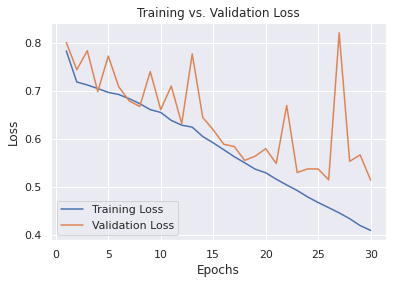

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, label = "Training Loss")
plt.plot(epochs, val_loss, label = "Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training vs. Validation Loss")
plt.legend()

In [ ]:
scores = model_final.evaluate(test_generator)
print("The test set accuracy was: ", scores[1])

821/821 [==============================] - 106s 129ms/step - loss: 0.5169 - accuracy: 0.8219
The test set accuracy was:  0.821905255317688


In [ ]:
features = np.zeros(shape=(test_length, number_classes)) # from summary above
labels = np.zeros(shape=(test_length, number_classes)) # 4 = number of classes
i = 0

for inputs_batch, labels_batch in tqdm(test_generator):
        features_batch = model_final.predict(inputs_batch)
        features[i * batch: (i + 1) * batch] = features_batch
        labels[i * batch : (i + 1) * batch] = labels_batch
        i += 1
        if i  * batch >= test_length:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break

  0%|          | 0/821 [00:00<?, ?it/s]

### Confusion Matrix

In [ ]:
# predictions = multilabel_predict_test = model_final.predict(test_generator, 
#                                                        batch_size = batch, 
#                                                        verbose=1, 
#                                                        steps = test_steps)

In [ ]:
#predictions

In [ ]:
y_hat = np.argmax(features, axis=1)
y_hat

array([3, 3, 3, ..., 3, 3, 3])

In [ ]:
y_actual = np.argmax(labels, axis=1)
y_actual

array([3, 3, 3, ..., 3, 1, 1])

In [ ]:
# extract the patient id number from the Path variable (index 2 in the path)
# path_split_test =  test_labels.Path.str.split("/", expand = True)
# test_labels['ID'] = path_split_test[2]

# # merge the race labels with the main label dataset
# test_labels = test_labels.merge(race_labels, on = 'ID')

In [ ]:
# black_african_american_index_test = (test_labels.PRIMARY_RACE.str.contains('Black', na = False))
# test_labels.loc[black_african_american_index, 'Race'] = 'Black/African American'

# white_index_test = (test_labels.PRIMARY_RACE.str.contains('White', na = False))
# test_labels.loc[white_index, 'Race'] = 'White'

# asian_index_test = (test_labels.PRIMARY_RACE.str.contains('Asian', na = False))
# test_labels.loc[asian_index, 'Race'] = 'Asian'

# native_american_index_test = (test_labels.PRIMARY_RACE.str.contains('Native|Indian', na = False, regex = True))
# test_labels.loc[native_american_index, 'Race'] = 'Native American'

In [ ]:
# test_labels.Race.value_counts(dropna = False)
# test_labels = test_labels.dropna(subset=['Race'])

In [ ]:
# test_labels.Race

In [ ]:
# test_labels.Race.iloc[np.where(test_labels.Race == 'White')] = 3

In [ ]:
# test_labels.Race.iloc[np.where(test_labels.Race == 'Black/African American')] = 1

In [ ]:
# test_labels.Race.iloc[np.where(test_labels.Race == 'Asian')] = 0

In [ ]:
# test_labels.Race.iloc[np.where(test_labels.Race == 'Native American')] = 2

In [ ]:
# test_labels.Race.value_counts()

In [ ]:
# y_actual = np.array(test_labels.Race)

In [ ]:
# y_actual = np.argmax(test_labels.Race, axis = 1)
# y_actual

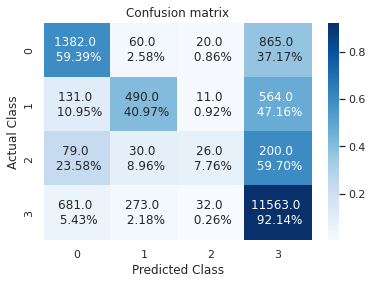

In [ ]:
def plot_confusion_matrix(y_label, y_pred, title='Confusion matrix'):
    ### TODO 1

    if type(y_pred) == 'numpy.ndarray':
      y_pred_vector = y_pred.tolist()
    else:
      y_pred_vector = y_pred

    if type(y_label) == 'numpy.ndarray':
      y_label_vector = y_label.tolist()
    else:
      y_label_vector = y_label

    classes = np.unique(y_label_vector)
    num_classes = len(np.unique(y_label_vector))
    matrix = np.zeros((num_classes, num_classes))
    for truth in range(len(classes)):
      for prediction in range(len(classes)):
        matrix[truth, prediction] = np.sum((y_label_vector == classes[truth]) & (y_pred_vector == classes[prediction]))

    matrix_percent = matrix/ (matrix.sum(axis  = 1)[:,None])



    labels = (np.asarray(["{0} \n {1:.2%}".format(number, percent) for number, percent in zip(matrix.flatten(), matrix_percent.flatten())])).reshape(num_classes, num_classes)
    ax1 = sns.heatmap(matrix_percent, annot=labels, cmap='Blues', fmt = '')
    ax1.set_title(title)
    ax1.set_xlabel('Predicted Class')
    ax1.set_ylabel('Actual Class')
    plt.show()


  
plot_confusion_matrix(y_actual, y_hat)

0 = Asian 

1 = Black/African American

2 = Native American

3 = White

In [ ]:
print(classification_report(y_actual, y_hat, target_names = ['Asian', 'Black/African American', 'Native American', 'White']))

                        precision    recall  f1-score   support

                 Asian       0.61      0.59      0.60      2327
Black/African American       0.57      0.41      0.48      1196
       Native American       0.29      0.08      0.12       335
                 White       0.88      0.92      0.90     12549

              accuracy                           0.82     16407
             macro avg       0.59      0.50      0.53     16407
          weighted avg       0.80      0.82      0.81     16407



### PR - AUC

In [ ]:
y_actual_flat = y_actual.flatten()
y_hat_flat = y_hat.flatten()

# Assign class numbers
Asian = 0
Black_African_American = 1
Native_American = 2
White = 3 

In [ ]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(number_classes):
    precision[i], recall[i], _ = precision_recall_curve(labels[:, i], features[:, i])
    average_precision[i] = average_precision_score(labels[:, i], features[:, i])

# get average pr score over all classes
precision["micro"], recall["micro"], _ = precision_recall_curve(
    labels.ravel(), features.ravel()
)
average_precision["micro"] = average_precision_score(labels, features, average="micro")

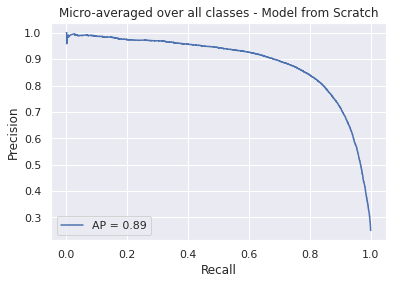

In [ ]:
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes - Model from Scratch")

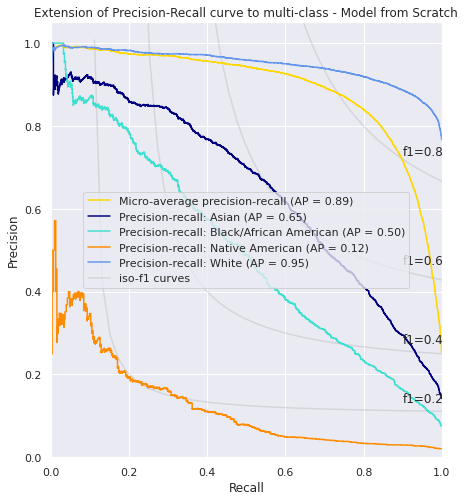

In [ ]:
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue"])
classes = ['Asian', 'Black/African American', 'Native American', 'White']
_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(number_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall: {classes[i]}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class - Model from Scratch")

plt.show()